As it is (without anything downloaded and always with 1 epoch when needed), the running time of the whole notebook is (approximately) <span style="background-color: lightblue"> 13 minutes</span>.

<span style="background-color: yellow"> </span>

#### Libraries

In [1]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification
from torchsummary import summary as torchsummary
from torchinfo import summary as torchinfosummary

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    BertModel                        # BERT base model
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

# from trl import (
#     SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
#     DPOConfig, DPOTrainer,
#     RewardTrainer, RewardConfig
# )
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_19769/1415056217.py:15: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources            # package and dependency management
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.re

In [2]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# A) CONCEPTS: Fine-tuning and Alignement-tuning

<span style="background-color: yellow">Fine-tuning or not?</span>:
- If we instantiate a model as `model = BertForMaskedLM(config)` we are only downloading the architecture, so we have to do the training from scratch and it is not fine-tuning;
- If we use `model = BertForMaskedLM.from_pretrained("bert-base-uncased")`, we are doing **transfer learning**. From here we have two main options:
    1. <span style="background-color: orange">Freeze the parameters</span>. In this case
        - if we do not add layers, we are **not doing fine-tuning** but using a model trained by others; 
        - if we add for example a classifier on top of the frozen model, and train only the classifier, we are doing **feature extraction**, which still is **not fine-tuning** because the original model is not updated;
    2. <span style="background-color: orange">Not freeze (all or some of) the parameters</span>: in this case we are doing fine-tuning becuase the weights are already trained by we modify them (a little) to adapt them to our objective during training. This is **continual learning**, and is the **selective** option of PEFT;
    3. <span style="background-color: orange">Add layers "internally" to the model</span>: this is fine tuning because we are modifying the original architecture. This is the **additive** or **reparameterization** options of PEFT;

## Fine-Tuning vs Alignement-tuning

Fine-tuning LLMs adapts pre-trained models to specif tasks/domains using domain-specific data. This process adjust model's parameters to improve task performance, and is useful if you have a limited dataset. Moreover it is time and resources efficient. We should pay attention to **catastrophic forgetting**, to prevent the model from losing its initial broad knowledge. Two main approaches to optimize language models:
1. <span style="background-color: yellow">FINE-TUNING</span>: improve the general features of a model on a specific task, or <span style="background-color: pink">"learn the task"</span>. This can be done in various ways:
    1. Self-supervised fine-tuning;
    2. SFT supervised fine-tuning:
        - Full fine-tuning;
        - PEFT Parameter-efficient fine-tuning (<span style="background-color: orange">adapters and LoRA</span>);
2. <span style="background-color: yellow">ALIGNEMENT-TUNING</span>: improve the behaviour and alignement of a model on the human preferences, or <span style="background-color: pink">"become similar to humans"</span>. This is done with:
    - Instruction-tuning, which is supervised, and then (one or the other):
        1. RHLF: reinforcement learning from human feedback, or reward-modelling;
        2. DPO: direct preference optimization, which does not need rewards and is directly controlled by humans.

| Aspect                         | <span style="background-color: yellow">FINE-TUNING</span>              | <span style="background-color: yellow">ALIGNEMENT-TUNING</span>  |
|-------------------------------|--------------------------------------------------|---------------------------------------------------|
| **Main Goal**                 | Task-specific skill improvement                  | Align model behavior with human intent            |
| **Data Format**              | Input → Target (e.g., text → label or answer)    | Instruction + Response, Human Preference pairs    |
| **Supervision Type**         | Supervised or semi-supervised                    | Supervised (instructions), Reinforcement (RLHF), or Preference Optimization (DPO) |
| **Use Case**                 | Classification, summarization, translation, etc. | Chatbots, assistants, safe and helpful responses  |
| **Model Focus**              | Learning the correct output                      | Learning *how to behave* appropriately            |
| **Parameter Updates**        | Full model (or partial via PEFT)                 | Usually full model tuning in multiple stages      |
| **Typical Final Goal**       | Accuracy, F1, BLEU, etc.                         | Helpfulness, safety, alignment with human values  |

## Fine-Tuning

### 1) Self-Supervised fine-tuning

### 2) Supervised fine-tuning

We can do:
1.  <span style="background-color: yellow"> full fine-tuning </span>. Usually, during fine-tuning, one trains again the model (maybe changing some hyperparameter), starting from its good weights. However this is
    - Time-consuming and resource-demanding;
    - Risk of overfitting, due to th ehigh number of parameters;
    - It need labeled data;
    - Risk of catastrophic forgetting, leading to a loss of the pre-trained knowledge. Instead, we want to do **continual learning**.
2. <span style="background-color: yellow"> PEFT parameter-efficient fine-tuning</span>. For these reason we ise PEFT (reduce the number of trainable parameters), which can be **selective/additive/reparameterization** fine-tuning.

    1. **Selective**: update only some layers. Not so useful for transformers due to their higher number of parameters;
    2. **Additive**: add some task-specific layers on top of the already trained model to keep it knowledge and do not train everything again.
        - In transformers, this additive layers are added after amulti-head attention or/and after the feed forward net. This is the idea of <span style="background-color: orange">adapters</span>, which introduce a bottleneck for reducing temporarily the the embeddings dimensions. Then the dim is restored, not to change the transformer architecture. An example is at the end of **1b)**
    3. **Reparameterization** (es <span style="background-color: orange">LoRA</span>, low-rank adaptation or QLoRA, quantized LoRa, or DoRA, Weight-decomposed Low-rank Adaptation): the idea is to replace for example a neet with 10-8 neurons (80 parmeters) with 10-x and x-8 parameters (for a total of 10*x+x*8=x*18<80 learnable parameters)

QLoRA with [notebook](https://www.coursera.org/learn/generative-ai-engineering-and-fine-tuning-transformers/ungradedWidget/3swEe/optional-lab-qlora-with-hugging-face):

- Quantization: in an interval $I=[-1,1]$ define a $N$-bit quantization by discretizing $I \rightarrow I/2^{N}$. This reduces the memory and the number of parameters used in fine-tuning.

# 1a) Simple Fine-Tuning of a downloaded pre-trained model

Continual learning, doing fine-tuning on the whole pre-trained model

## Dataset, tokenizer, dataloader

We will not need the collate function because we will apply the max padding in the `tokenize_function`, so the dataloader can use its default collate

Load dataset and cut it

In [3]:
dataset = load_dataset("yelp_review_full")
dataset["train"] = dataset["train"].select([i for i in range(1000)])
dataset["test"] = dataset["test"].select([i for i in range(200)])

dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Define a function to tokenize examples
def tokenize_function(examples):
    # Tokenize the text using the tokenizer
    # Apply padding to ensure all sequences have the same length
    # Apply truncation to limit the maximum sequence length
    return tokenizer(examples["text"], padding= "max_length", truncation = True)


# Apply the tokenize function to the dataset in batches
tokenized_datasets = dataset.map(tokenize_function, batched=True)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Remove the text column because the model does not accept raw text as an input
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the label column to labels because the model expects the argument to be named labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format of the dataset to return PyTorch tensors instead of lists
tokenized_datasets.set_format("torch")

# Create a training data loader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle = True, batch_size = 2)

# Create an evaluation data loader
eval_dataloader = DataLoader(tokenized_datasets["test"], shuffle = False, batch_size = 2)

## Pre-trained model

Here, you'll load a pretrained classification model from Hugging Face with 5 classes:

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train and evaluate function 

In [7]:
def train_model(model,tr_dataloader):

    # Create a progress bar to track the training progress
    progress_bar = tqdm(range(num_training_steps))

    # Set the model in training mode
    model.train()
    tr_losses=[]
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0 
        # Iterate over the training data batches
        for batch in tr_dataloader:
            # Move the batch to the appropriate device
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward pass through the model
            outputs = model(**batch)
            # Compute the loss
            loss = outputs.loss
            # Backward pass (compute gradients)
            loss.backward()
            
            total_loss += loss.item()
            # Update the model parameters
            optimizer.step()
            # Update the learning rate scheduler
            lr_scheduler.step()
            # Clear the gradients
            optimizer.zero_grad()
            # Update the progress bar
            progress_bar.update(1)
        tr_losses.append(total_loss/len(tr_dataloader))
    #plot loss
    plt.plot(tr_losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()  

def evaluate_model(model, evl_dataloader):
    # Create an instance of the Accuracy metric for multiclass classification with 5 classes
    metric = Accuracy(task="multiclass", num_classes=5).to(device)

    # Set the model in evaluation mode
    model.eval()

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Iterate over the evaluation data batches
        for batch in evl_dataloader:
            # Move the batch to the appropriate device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass through the model
            outputs = model(**batch)

            # Get the predicted class labels
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Accumulate the predictions and labels for the metric
            metric(predictions, batch["labels"])

    # Compute the accuracy
    accuracy = metric.compute()

    # Print the accuracy
    print("Accuracy:", accuracy.item())

In [8]:
# train_model(model=model,tr_dataloader=train_dataloader)

# torch.save(model, 'my_model.pt')

it takes 4m 35s

In [9]:
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wFhKpkBMSgjmZKRSyayvsQ/bert-classification-model.pt'
# model.load_state_dict(torch.load('bert-classification-model.pt',map_location=torch.device('cpu')))

It takes > 32m

In [10]:
#evaluate_model(model, eval_dataloader)

# 1b) Fine-tuning a custom pre-trained model 

Fine-tuning: full fine-tuning, last-layer fine-tuning, adapter fine-tuning

We want to do a predictions on the IMDB dataset. We approach the problem in two ways, the first is **training from scratch** using of a transformer model defined by us; the second is by **fine-tuning** the already-trained model on the AG NEWS dataset. Now there is a list of the main steps in both cases, with also a comparison with the Hugging Face procedure for the first approach.

**FROM SCRATCH** 

1. Download the dataset, analyze it, split into train-test and define the dataloader;
2. Define the model we want to train;
3. Train **from zero**;
4. Evaluate: <span style="background-color: yellow"> 83% accuracy </span> ;
5. Do some inference.


**FINE-TUNING**

1. Take the **same model as before**, and train it **from zero** on the AG_NEWS dataset. **The performances are better now**: <span style="background-color: yellow"> 90% accuracy </span> ;
2. do fine-tuning of the whole model (this means that **we continue the training**: we have saved the weights from the training of point 1., and we move them a little to improve performances) <span style="background-color: yellow"> 86% accuracy </span> ;
3. do fine-tuning of the only last layer (this is faster, but with fewer final accuracy) <span style="background-color: yellow"> 64% accuracy </span> ;
4. do fine-tuning with **adapter**, getting again <span style="background-color: yellow"> 86% accuracy </span> but in less time.

## FROM SCRATCH

### Dataset, tokenizer

The following code loads the IMDB dataset, and then create a train_ and test_iter.

The **IMDB dataset** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular dataset for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

 Dataset composition

- **Reviews**: The dataset consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The dataset is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The dataset is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

In [11]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

In [12]:
imdb_label = {0: "negative review", 1: "positive review"}
num_class = len(set([label for (label, text) in train_iter]))
num_class == 2

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [13]:
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

glove_embedding = GloVe(name = "6B", dim = 100, cache = './GloVe_model/')
vocab = build_vocab_from_iterator(glove_embedding.stoi, 0 ,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) 

vocab_size=len(vocab)


### Collate and Dataloader

In [14]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [15]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         0, 0, 1, 0, 1, 1, 0, 1]),
 tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0, 45,  8,  ...,  0,  0,  0],
         [ 4,  0,  0,  ...,  0,  0,  0],
         [ 0, 39,  4,  ...,  0,  0,  0]]))

### Positional Encoding

In [16]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, max_len=400002, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

### Model 

In [17]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        #self.emb = embedding=nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            max_len=400002 
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

model = Net(num_class=2,vocab_size=vocab_size).to(device)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Accuracy and predict

In [18]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

predict("I like sports and stuff", text_pipeline, model)

'negative review'

In [19]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

#evaluate(test_dataloader, model) #-->0.5

### Training

In [20]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_IMDB dataset small2.pth"
# train_model(model=model, 
#             optimizer=optimizer, 
#             criterion=criterion, 
#             train_dataloader=train_dataloader, 
#             valid_dataloader=valid_dataloader, 
#             epochs=2, 
#             save_dir=save_dir, 
#             file_name=file_name
#            )

The following has been trained on 100 epochs:

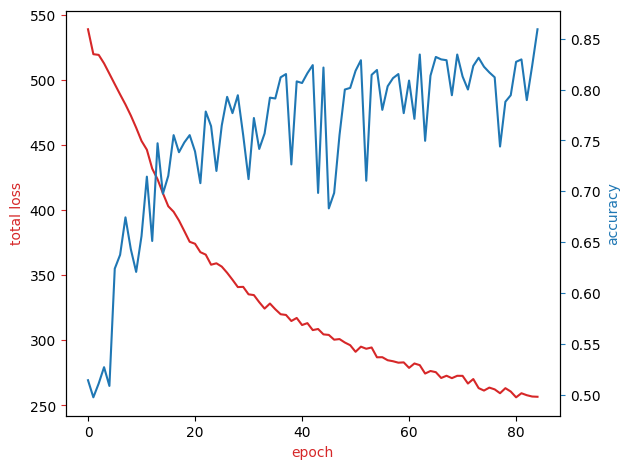

In [21]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

## FINE-TUNING (run 'from scratch' before)

We train the very same model as before but on the AG NEWS, obtaining better results on 100 epochs. Then do fine-tuning.

### train on AG NEWS

In [22]:
train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
num_class_ag_news

# Split the dataset into training and testing iterators.
train_iter_ag_news, test_iter_ag_news = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])

# Make the training set smaller to allow it to run fast as an example.
# IF YOU WANT TO TRAIN ON THE AG_NEWS DATASET, COMMENT OUT THE 2 LINEs BELOW.
# HOWEVER, NOTE THAT TRAINING WILL TAKE A LONG TIME
num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def label_pipeline(x):
   return int(x) - 1


def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader_ag_news = DataLoader(
    split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
valid_dataloader_ag_news = DataLoader(
    split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
test_dataloader_ag_news = DataLoader(
    test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)


model_ag_news = Net(num_class = 4,vocab_size = vocab_size).to(device)
model_ag_news.to(device)


LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_AG News small1.pth"
# train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)

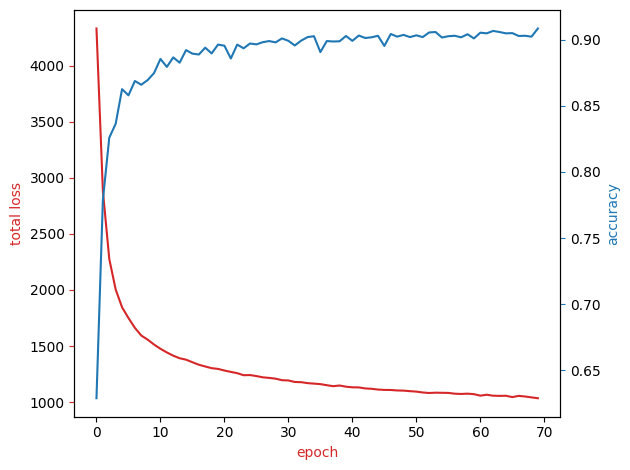

In [23]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

It takes more than 5 mins:

In [24]:
# urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
# model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
# model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
# evaluate(test_dataloader_ag_news, model_ag_news_)

### Fine-Tuning

Suppose we have our trained model:

In [25]:
# it takes approximately 5 min

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class = 4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location = device))

<All keys matched successfully>

We have to change the last layer from 4 (AG NEWS) to 2 (IBDM)

In [26]:
model_fine1.classifier
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

Original final layer: Linear(in_features=100, out_features=4, bias=True)
Input dimention  final layer: 100
Original final layer: Linear(in_features=100, out_features=2, bias=True)
Input dimention  final layer: 100


#### All

This will train with all the weights

In [27]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine1.pth"
# train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

#### last layer

In [28]:
for param in model_fine1.parameters():
    param.requires_grad = False

LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
# train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

## Fine-tuning with adapter (run 'from scratch' before)

Now suppose that we have trained the same model as before on the AG NEWS dataset and are again on the point of doing fine-tuning. Instead of doing fine-tuning as above, we use an adapter. So first we load the weights of the model in a new model that we call model_adapters, chenge the final layer from 4 to 2 as usual for IBDM and finally freeze all the parameters:

In [29]:
#it takes approx 5 min

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_adapters = Net(vocab_size = vocab_size, num_class = 4).to(device)
model_adapters.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

KeyboardInterrupt: 

In [ ]:
for param in model_adapters.parameters():
    param.requires_grad = False

dim = model_adapters.classifier.in_features
model_adapters.classifier = nn.Linear(dim, 2)

### Adapter class

In [ ]:
class FeatureAdapter(nn.Module):
    """
    Attributes:
        size (int): The bottleneck dimension to which the embeddings are temporarily reduced.
        model_dim (int): The original dimension of the embeddings or features in the transformer model.
    """
    def __init__(self, bottleneck_size = 50, model_dim = 100):
        super().__init__()
        self.bottleneck_transform = nn.Sequential(
            nn.Linear(model_dim, bottleneck_size),  # Down-project to a smaller dimension
            nn.ReLU(),                             # Apply non-linearity
            nn.Linear(bottleneck_size, model_dim)  # Up-project back to the original dimension
        )

    def forward(self, x):
        """
        Forward pass of the FeatureAdapter. Applies the bottleneck transformation to the input
        tensor and adds a skip connection.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, model_dim).

        Returns:
            Tensor: Output tensor after applying the adapter transformation and skip connection,
                    maintaining the original input shape.
        """
        transformed_features = self.bottleneck_transform(x)  # Transform features through the bottleneck
        output_with_residual = transformed_features + x      # Add the residual connection
        return output_with_residual

The `Adapted` class wraps this adapter functionality around any specified linear layer, enhancing its output with the non-linearity of a ReLU activation function. This setup is particularly useful for experimenting with subtle architectural modifications in deep learning models, facilitating fine-tuning and potentially improving model performance on complex tasks.

In [ ]:
class Adapted(nn.Module):
    def __init__(self, linear ,bottleneck_size = None):
        super(Adapted, self).__init__()
        self.linear = linear
        model_dim = linear.out_features
        if bottleneck_size is None:
          bottleneck_size = model_dim//2   # Define default bottleneck size as half the model_dim

        # Initialize FeatureAdapter with calculated bottleneck_size and model_dim
        self.adaptor = FeatureAdapter(bottleneck_size = bottleneck_size, model_dim = model_dim)

    def forward(self, x):
        # First, the input x is passed through the linear layer
        x=self.linear(x)
        # Then it's adapted using FeatureAdapter
        x= self.adaptor(x)
        return x

### Adding adapters

We now add the adapter within the encoder. This means that we add the adapter on each encoder_layer of the encoder:

In [ ]:
N_layers = len(model_adapters.transformer_encoder.layers)

The bottleneck size is chosen to reduce the number of learnable paramters, that appear only in the adapter and in the final classifier layer.

In [ ]:
for n in range(N_layers):
  encoder = model_adapters.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)
    model_adapters.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

Now we can train it and we see that on 100 epochs we get 86%, as for the all fine-tuning, but in very less time:

In [ ]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapters.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_adapters.pth"
# train_model(model=model_adapters, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

# 1c) Fine-tuning a custom pre-trained model

Fine-tuning: LoRA

This is basically exactly the "fine-tuning" part of 1b). Indeed, in 1b), we could have started by defining the model, train it on AG_NEWS, and fine tune it on IMDB.

## From scratch

Since we are using the same IBDM dataset, use some codes from 1b)

### Dataset, tokenizer

The following code loads the IMDB dataset, and then create a train_ and test_iter.

The **IMDB dataset** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular dataset for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

 Dataset composition

- **Reviews**: The dataset consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The dataset is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The dataset is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

In [ ]:
imdb_label = {0: "negative review", 1: "positive review"}
num_class = len(set([label for (label, text) in train_iter]))
num_class == 2

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [ ]:
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

glove_embedding = GloVe(name = "6B", dim = 100, cache = './GloVe_model/')
vocab = build_vocab_from_iterator(glove_embedding.stoi, 0 ,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) 

vocab_size=len(vocab)


### Collate and Dataloader

In [ ]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [ ]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]),
 tensor([[ 0, 39,  0,  ...,  0,  0,  0],
         [ 0, 27, 27,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  4,  0,  ...,  0,  0,  0]]))

### Simple classifier

`freeze`: Whether to freeze the embedding layer.

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, num_classes,freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding.vectors.to(device),freeze=freeze)
        # An example of adding additional layers: A linear layer and a ReLU activation
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Here you can use a simple mean pooling

        x = torch.mean(x, dim=1)
        # Pass the pooled embeddings through the additional layers
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

In [ ]:
model=TextClassifier(num_classes = 2,freeze = True).to(device)

In [ ]:
def predict(text, model, text_pipeline):
    model.eval()
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return imdb_label[output.argmax(1).item()]

predict("the is a good movie",model,text_pipeline )

'negative review'

### Accuracy

In [ ]:
def evaluate(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
evaluate(test_dataloader , model, device)

50.0

### Train

In [ ]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=100, model_name="my_modeldrop"):
    cum_loss_list = []
    acc_epoch = []
    best_acc = 0
    file_name = model_name
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        cum_loss = 0
        for _, (label, text) in enumerate(train_dataloader):            
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        #print("Loss:", cum_loss)
        cum_loss_list.append(cum_loss)
        acc_val = evaluate(valid_dataloader, model, device)
        acc_epoch.append(acc_val)
        
        if acc_val > best_acc:
            best_acc = acc_val
            print(f"New best accuracy: {acc_val:.4f}")
            #torch.save(model.state_dict(), f"{model_name}.pth")
    
    #save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
    #save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")

In [ ]:
LR=1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model_name="model_imdb_freeze_true2"
#train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

In [ ]:
# model.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
# model.eval()
# evaluate(test_dataloader , model, device)

FileNotFoundError: [Errno 2] No such file or directory: 'model-imdb-freeze-true2.pth'

## LoRA with PyTorch

In [ ]:
# it takes approximately 3 minutes

model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

# Here, you freeze all layers:
for parm in model_lora.parameters():
    parm.requires_grad=False

model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)

In [ ]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):
        
        return self.linear(x) + self.lora(x)

Now replace with loRA and then do the train again

In [ ]:
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank = 2, alpha = 0.1).to(device)

## LoRA with HuggingFace: see notebook 5) 